In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct1'
os.chdir(new_path)


In [2]:
from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms,cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition
from qtpyt.tools import remove_pbc
from copy import deepcopy


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


In [4]:
def create_active_hamiltonian(H_cutcoupled, S_cutcoupled, index_left_Au, index_right_Au,  index_active_region):
    """
    Create the Hamiltonian H_active by retaining the left and right Au orbitals and
    the active region couplings within the bridge.

    Parameters:
    H_cutcoupled (np.ndarray): The Hamiltonian matrix after cutting couplings.
    index_active_region (list of int): Indices of the active orbitals within the bridge.

    Returns:
    np.ndarray: The Hamiltonian matrix H_active.
    """

    # Create a list of indices to retain
    indices_to_keep = index_left_Au + sorted(list(index_active_region)) + index_right_Au

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H_cutcoupled[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S_cutcoupled[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active[None,...], S_active[None,...]


### Control parameters

In [5]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [6]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


In [7]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

cutoff = [1,1e-2,1e-4,1e-5,1e-6,1e-8,1e-10,1e-18,1e-40]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

### Nodes obtained from LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

In [9]:
# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao[None,...])
remove_pbc(device_basis, S_lcao[None,...])


for co in cutoff:
    # Partition the device Hamiltonian matrix into tridiagonal nodes
    nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_lcao, len(leads_atoms.repeat(Nr)))

    # Print the nodes to verify the partitioning
    print(nodes)


[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]


### Nodes obtained from Hamiltonian that Subdiagonalizes C, N and H

In [10]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

for co in cutoff:
    # Partition the device Hamiltonian matrix into tridiagonal nodes
    nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)))

    print(nodes)


[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]


### Nodes obtained from Hamiltonian that Subdiagonalizes only C

In [11]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

for co in cutoff:
    # Partition the device Hamiltonian matrix into tridiagonal nodes
    nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)),cutoff=co)

    # Print the nodes to verify the partitioning
    print(nodes)


[0, 2376]
[0, 810, 1107, 1175, 1237, 1269, 1566, 2376]
[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1121, 1260, 1566, 2376]
[0, 810, 1157, 1260, 1566, 2376]
[0, 810, 1157, 1219, 1566, 2376]
[0, 810, 1157, 1219, 1566, 2376]


### Nodes obtained from Hamiltonian that Subdiagonalizes only H

In [12]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

cutoff = [1e-4,1e-5,1e-6,1e-8,1e-10,1e-18]
for co in cutoff:
    # Partition the device Hamiltonian matrix into tridiagonal nodes
    nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)),cutoff=co)

    # Print the nodes to verify the partitioning
    print(nodes)


[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1121, 1260, 1566, 2376]
[0, 810, 1121, 1260, 1566, 2376]
[0, 810, 1157, 1232, 1566, 2376]
[0, 810, 1157, 1219, 1566, 2376]


### Nodes obtained from Hamiltonian that Subdiagonalizes only N

In [13]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("N")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)


for co in cutoff:
    # Partition the device Hamiltonian matrix into tridiagonal nodes
    nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)),cutoff=co)

    # Print the nodes to verify the partitioning
    print(nodes)


[0, 810, 1116, 1219, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1116, 1260, 1566, 2376]
[0, 810, 1121, 1260, 1566, 2376]
[0, 810, 1157, 1260, 1566, 2376]
[0, 810, 1157, 1219, 1566, 2376]


### Conclusion
- The nodes list computed by `graph_partition.get_tridiagonal_nodes` depends on which Hamiltonian is passed into the function. The nodes computed using the Hamiltonian where C, N and H are subdiagonalized is different from that computed using LCAO Hamiltonian or the Hamiltonian where only C is subdiagonalized.
Playing with the cutoff parameter helps in some cases but no value of cutoff produced the right nodes when the function is applied on the lcao Hamiltonian.
### Analysis
- When nodes are computed using Hamiltonian subdiagonalized by C, N and H

Nodes = [0, 810, 1116, 1260, 1566, 2376]

Total orbitals of Au = 2232

Total orbitals of Au_left = Total orbitals of Au_right = 1116

Since 1116 - 0 = 2376 - 1260 = 1116 these two values likely pick out the Au orbitals of the left and right leads.

The other values in the nodes list are 810 and 1566. These correspond to the orbitals of the Au atoms that are not included in the Au tip.

The total number of orbitals from C,N and H = 1260-1116 = 144

Therefore, 

0 to 810 = Au left lead orbitals not in tip

810 to 1116 = Au orbitals left tip

1116 to 1260 = C, N, H orbitals

1260 to 1566 = Au orbitals right tip

1566 to 2376 = Au right lead orbitals not in tip

This is the set of nodes that consistently gives us the right T(E) in the transmission function tests provided in the transmission_question.ipynb notebook

- When nodes are computed using Hamiltonian subdiagonalized by only C or directly from the LCAO Hamiltonian

Nodes = [0, 810, 1116, 1219, 1260, 1566, 2376]. 

We see the appearance of an additional 1219 in the nodes list

Total C orbitals = 78

Total N orbitals = 26

Total H orbitals = 40

1219 - 1116 = 103 

1260 - 1219 = 41

Indices 1116 to 1219 picks out the orbitals of the bridge molecule from atom 124 to atom 134 in the figure below while 1219 to 1260 picks out atoms 135 to 139. Therefore, node 1219 seems to divide the Hamiltonian of the bridge molecule in a strange way. 

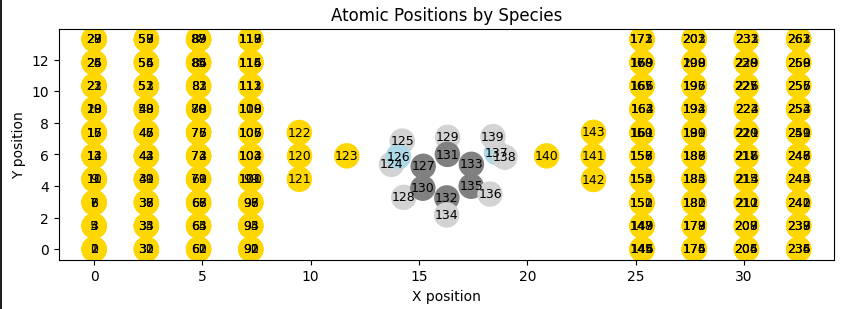



### Questions

- Can you explain what the `graph_partition.get_tridiagonal_nodes` is supposed to do?
    - Is it right to conclude that the `graph_partition.get_tridiagonal_nodes` is meant to pick out chunks of the Hamiltonian that correspond to left lead, bridge and right lead? 
    - If so, has it been your experience (or do you assume) that `graph_partition.get_tridiagonal_nodes` is only meant to work correctly if all the elements in the bridge are subdiagonalized?

### Smaller active Hamiltonian nodes

We move ahead with the assumption that in order to obtain the transmission function, regardless of the type of Hamiltonian (subdiagonalized, atoms being subdiagonalized etc), the nodes have to be list that divide the Hamiltonian into [0,lead_left orbitals,left_tip orbitals,bridge orbitals,right_tip orbitals,right_lead orbitals,].

The computation in all the previous cell had the same size as the lcao Hamiltonian regardless of the postprocessing done to it. However, if we try to reduce the size of the Hamiltonian after the cutcoupling procedure to extract only the active Hamiltonian, the nodes computed using the LCAO Hamiltonian would no longer be valid. 

Consider an active space Hamiltonian that includes all LCAO orbital of Au and N and the subdiagonalized C 2pz orbitals. Let us compute by hand what the right nodes should be in this case. Since the Au is unchanged, the left leads region of the nodes should be [0,810,1116]. In the molecule, we have 2x13 orbitals of N and 6x1 orbitals of C 2pz. Therefore the next node = 1116+26+6 = 1148. The right tip and lead will be 1148+(1116-810)=1454 and 1454+(810-0)=2264 since the lead orbitals are symmetric about the molecule. Hence nodes = [0, 810, 1116, 1148, 1454, 2264]

The code below shows how variables need to be changed in order to get the right nodes.

In [14]:
from ase import Atoms

# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Add N orbitals to the active space
N_indices = get_species_indices(atoms, ("N"))
basis_N_region = basis[N_indices]
index_N_region = basis_N_region.get_indices()

relevant_index = list(index_active_region) + list(index_N_region)

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

nodes = [0, 810, 1116, 1260, 1566, 2376]
index_left_Au = list(range(nodes[0], nodes[2]))  # From 0 to end of left Au region
index_right_Au = list(range(nodes[3], nodes[-1]))  # From start of right Au region to the end

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_subdiagonal = rotate_matrix(H_lcao, Usub)[None, ...]
S_subdiagonal = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification

H_cutcoupled = deepcopy(H_subdiagonal)
S_cutcoupled = deepcopy(S_subdiagonal)


# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)

H_active, S_active = create_active_hamiltonian(H_cutcoupled[0], S_cutcoupled[0], index_left_Au, index_right_Au, relevant_index)

non_h_atoms = [atom for atom in device_atoms if atom.symbol != 'H']

device_atoms_no_H = Atoms(symbols=[atom.symbol for atom in non_h_atoms],
                          positions=[atom.position for atom in non_h_atoms],
                          pbc=device_atoms.get_pbc(),
                          cell=device_atoms.get_cell())

reduced_basis_dict = {"Au":9,"C":1,"N":13}
device_basis_no_H = Basis.from_dictionary(device_atoms_no_H, reduced_basis_dict)

for co in cutoff:
    # Partition the device Hamiltonian matrix into tridiagonal nodes
    nodes = graph_partition.get_tridiagonal_nodes(device_basis_no_H, H_active[0], len(leads_atoms.repeat(Nr)),cutoff=co)

    # Print the nodes to verify the partitioning
    print(nodes)

[0, 810, 1116, 1148, 1454, 2264]
[0, 810, 1116, 1148, 1454, 2264]
[0, 810, 1116, 1148, 1454, 2264]
[0, 810, 1116, 1148, 1454, 2264]
[0, 810, 1129, 1135, 1454, 2264]
[0, 810, 1129, 1134, 1454, 2264]
